# Tutorial on the RUS equations (Rayleigh-Ritz method in code)

Show the tools in that RUS toolbox through a worked example.  This notebook is for learning purposes, therefore you will see lots of visualizations just to take you by the hand across the algorithm.

# Example: Sphere of Copper from De Rue (1996)

The Master's thesis of [Jeffrey De Rue (1996)](https://uva.computationalscience.nl/papers/archive/Rue96_1.pdf) dealt in detail with the normal modes of spheres using semi-analytical calculations (those of Lamb 1881) and using the variational method of Vissher et al. (1991).  Here I reproduce the variational method results of his **Table 6.1** for a sphere of copper of 3.0 meters in diameter.  His thesis was part of the GRAIL project to create a massive spherical antenna to detect gravitational waves.

I adapted the codes of the [PALab](https://github.com/PALab) for [RUS](https://github.com/PALab/RUS) to reproduce the results. These codes were provided by Zadler et al. (2004) and translated to Python by [Paul Freeman](https://github.com/paul-freeman) in 2015. The functions needed are in the file `rus_tools.py`.  The formula for the spheroid in Zadler et al. (2004) has a typo on the multiplying factor (it should be $\pi/2$ instead of $4\pi$!).

The eigenvalues are related to the resonant frequencies of the object!!!

> **Remember to shutdown the kernel and restarting it to clear the memoization global variables before a new run!!!**

The cell below is an example of a typical forward model: given the elastic parameters and shape of an object, calculate its normal mode frequencies and, if needed, the displacements at a given location on or within it.

In [1]:
# Download a data file from github, if it doesn't exist
# !test ! -f rus_tools.py && wget 'https://raw.githubusercontent.com/edur409/Circumferential-Surface-Waves/main/RUS/rus_tools.py'

In [2]:
%%time
import sys
import scipy
import numpy
import scipy.linalg.lapack as lapack
import scipy.linalg as la
from math import sqrt
import rus_tools as rus

def c_l(lam, mu, rho):
    return 1000*numpy.sqrt((lam + 2*mu)/rho)

def c_t(mu, rho):
    return 1000*numpy.sqrt(mu/rho)

# Inputs
# Aluminium: Lam: 53.0989  , Mu: 26.0 , Rho: 2.710
# Copper: Lam: 105.6 GPa, Mu: 48.3 GPa, Rho: 8.933 g/cm^3
Lam = 105.6 # GPa 53.0989#
Mu = 48.3 # GPa 26.7195 
rho = 8.933 # cm^3 2.710 #

print('Vp: ', c_l(Lam, Mu, rho))
print('Vs: ', c_t(Mu, rho))

# Shape of object and dimensions
shape = 2 # 1 for cylinder.  2 for a sphere
args = {'nfreq': 16, 'outeigen': None}
a = {'c11': Lam + 2*Mu, 'c44': Mu}
dimension1 = 150.0 # Radius 1 4.422/2 #
dimension2 = 150.0 # Radius 2 4.422/2 #
dimension3 = 150.0 # Radius 3  # Use this: 150.0e4 and cylinder shape = 1 for infinite cylinder #6.414/2 #
dimensions = [dimension1, dimension2, dimension3]

# Elastic matrix and stiffness tensor
cm = rus.make_cm(a, hextype=None) # Voigt notation 6X6 array
cijkl = rus.stiffness(cm) # Full tensor 3x3x3x3 array
# print('DATA C/ ',cijkl.reshape(81, order='F')) # Vissher et al. (1991) Fortran code for Cijkl

# Code starts
d = 8 # N order or NN in Vissher et al. 1991
problem_size = int(3*(d + 1)*(d + 2)*(d + 3)/6) # R in Vissher et al. 1991

tabs, irk = rus.index_relationship(d, problem_size)

e = rus.e_fill(tabs, dimensions, rho, shape, irk)

gamma = rus.gamma_fill(tabs, dimensions, cm, shape, irk)

print("done preparing matrices") # It works find until here

jobz = 'N'
if args['outeigen'] == None: #args.outeigen == None:
    jobz = 'N'
else:
    jobz = 'V'

# Solves the eigenproblem for each block of the block-diagonal matrix Gamma
# Each matrix in the block is positive-difinite
w = []
eigvals = []
eigvect = []
for k in range(8):
    # lapack routine
    #w_temp, _, _ = lapack.dsygv(gamma[k], e[k], itype=1, jobz=jobz, uplo='U') 
    w_temp, v_temp = la.eigh(gamma[k], e[k], lower=False, eigvals_only=False, type=1, overwrite_a=True, overwrite_b=True, check_finite=False)
    w.append(w_temp)
    eigvals.append(w_temp)
    eigvect.append(numpy.transpose(v_temp)) # Transpose if needed!

# start eigen vectors (block)
r = problem_size
z = numpy.zeros((r,r)) # Matrix of eigenvectors matching tabs array
irf = 0
for k in range(8):
    for ir1 in range(irf,irf+irk[k]):
        for ir2 in range(irf,irf+irk[k]):
            z[ir2][ir1] = eigvect[k][ir2-irf][ir1-irf]
    for ir1 in range(irk[k]+irf,r):
        for ir2 in range(irf,irf+irk[k]):
            z[ir2][ir1] = 0.0
    irf += irk[k]
# end eigen vectors (block)    

# Sort eigenvalues
wsort = numpy.zeros(problem_size)
i = 0
for k in range(8):
    for ir1 in range(irk[k]):
        wsort[i] = w[k][ir1]
        i += 1
wsort.sort()

# Choose the unique values inside the eigenvalue array
eigenfreqs = numpy.unique(numpy.round(1e5*numpy.sqrt(wsort[6:])/(2.0*numpy.pi), decimals=4))

i = 0
ir1 = 0
while ir1 < args['nfreq']:#args.nfreq:
    ir1 += 1
    print(" f%d = %f" % (ir1, eigenfreqs[i]))
    i += 1


Vp:  4757.64363463834
Vs:  2325.2780841414174
irk[0]=75
irk[1]=50
irk[2]=50
irk[3]=60
irk[4]=60
irk[5]=75
irk[6]=75
irk[7]=50
done preparing matrices
 f1 = 617.078600
 f2 = 654.085000
 f3 = 891.787700
 f4 = 953.500300
 f5 = 975.463800
 f6 = 1252.356600
 f7 = 1256.960200
 f8 = 1263.774600
 f9 = 1396.059200
 f10 = 1422.480700
 f11 = 1511.648800
 f12 = 1551.122900
 f13 = 1661.628300
 f14 = 1762.427300
 f15 = 1795.813500
 f16 = 1833.659600
CPU times: user 3.19 s, sys: 24.1 ms, total: 3.21 s
Wall time: 593 ms


## The sorted eigenvalues

notice the repetitions of eigenvalues.

In [3]:
numpy.round(1e5*numpy.sqrt(wsort[6:])/(2.0*numpy.pi), decimals=4)

array([  617.0786,   617.0786,   617.0786,   617.0786,   617.0786,
         654.085 ,   654.085 ,   654.085 ,   654.085 ,   654.085 ,
         891.7877,   891.7877,   891.7877,   953.5003,   953.5003,
         953.5003,   953.5003,   953.5003,   953.5003,   953.5003,
         975.4638,   975.4638,   975.4638,   975.4638,   975.4638,
         975.4638,   975.4638,  1252.3566,  1252.3566,  1252.3566,
        1252.3566,  1252.3566,  1252.3566,  1252.3566,  1252.3566,
        1252.3566,  1256.9602,  1256.9602,  1256.9602,  1256.9602,
        1256.9602,  1256.9602,  1256.9602,  1256.9602,  1256.9602,
        1263.7746,  1263.7746,  1263.7746,  1263.7746,  1263.7746,
        1396.0592,  1422.4807,  1422.4807,  1422.4807,  1511.6488,
        1511.6488,  1511.6488,  1511.6488,  1511.6488,  1511.6488,
        1511.6488,  1511.6488,  1511.6488,  1511.6488,  1511.6488,
        1551.1229,  1551.1229,  1551.1229,  1551.1229,  1551.1229,
        1551.1229,  1551.1229,  1551.1229,  1551.1229,  1551.1

# Organization of the indices for each k

If you want to reconstruct the displacements, you have to keep good track of the 8 individual eigenproblems solved above.  The function `index_relationship` did exactly that.  The matrix $\Gamma$ is a block-diagonal matrix of 8 blocks, therefore the arrays `tabs` and `irk` contain the values and size of the blocks for all the indices.  The plots below will help you visualize the contents of both arrays.

> tabs = (i, l, m, n) of size (R, 4) or (problem_size, 4).
> irk = order or size of the 8 individual blocks, the size is 8 (the number of $k$ values).

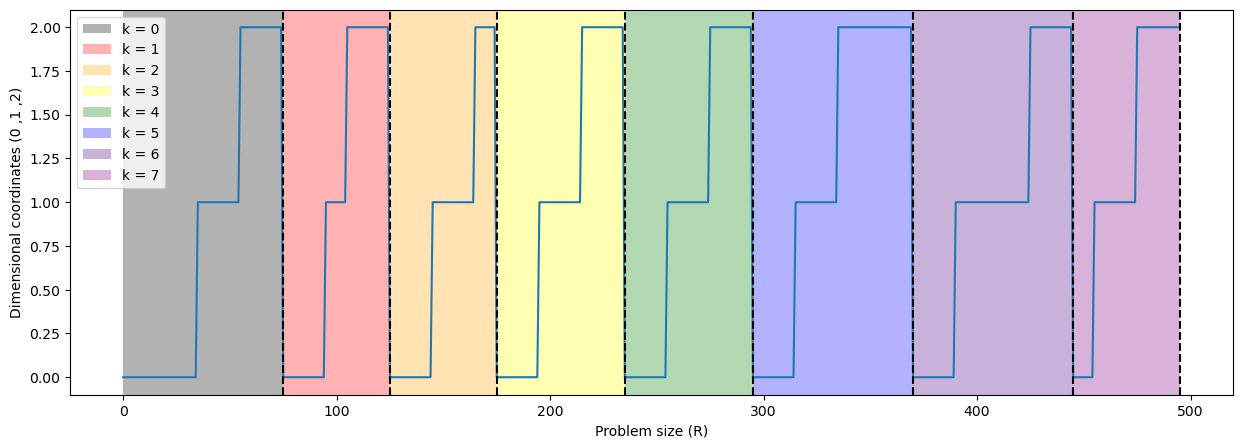

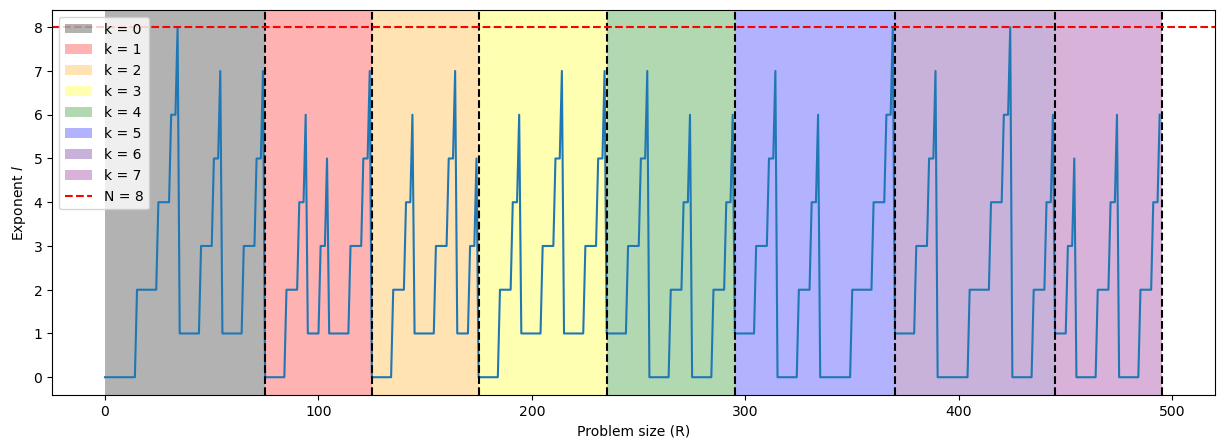

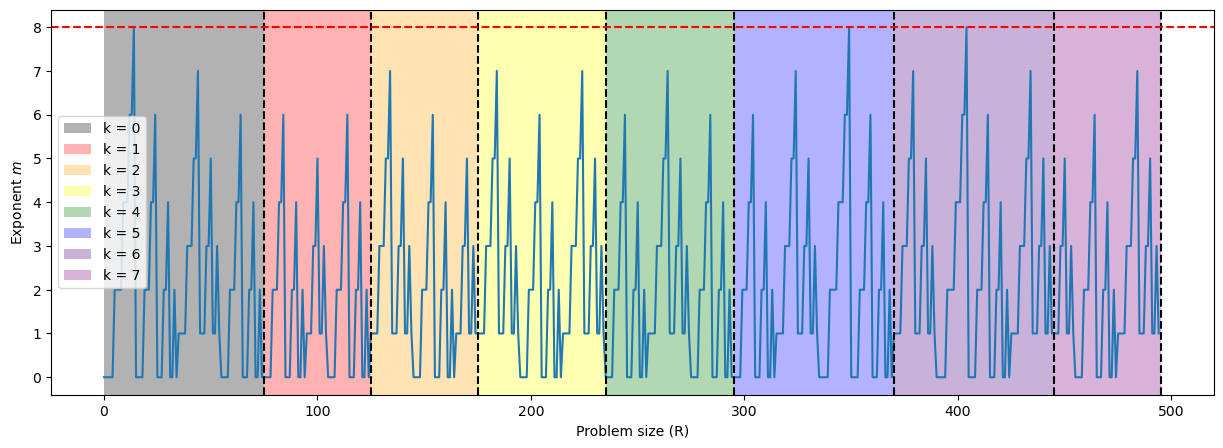

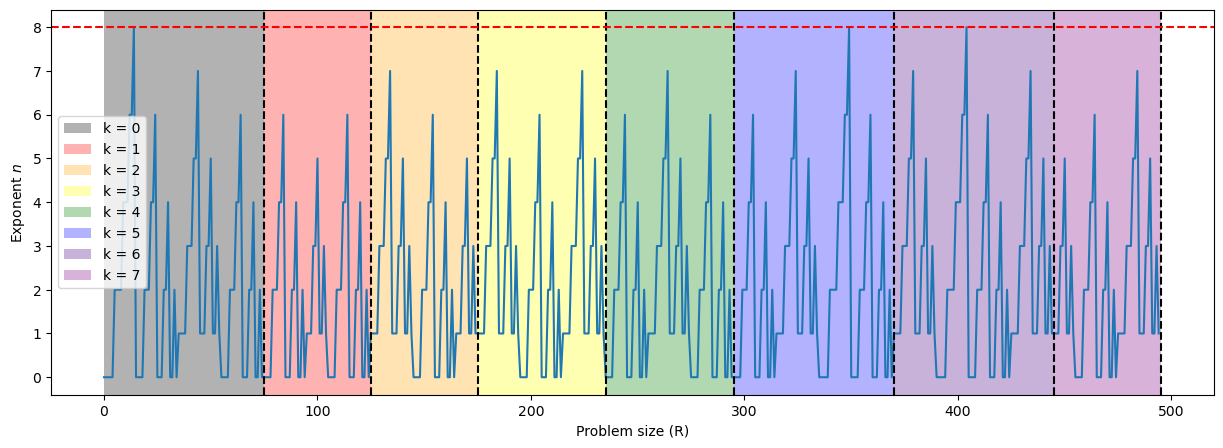

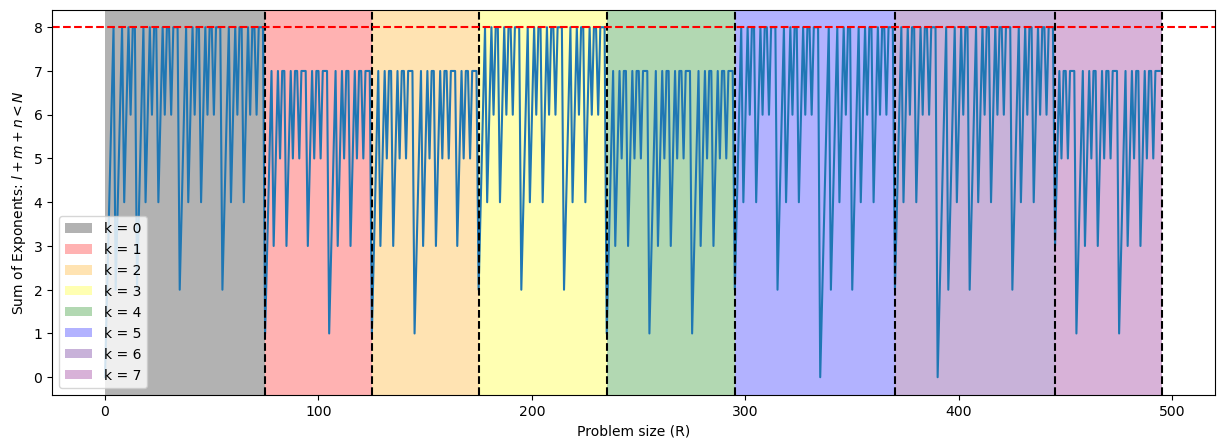

In [4]:
# Understand the tabs array through some plots
import matplotlib.pyplot as plt

block_colors = ['Black','Red', 'Orange', 'Yellow', 'Green', 'Blue', 'Indigo', 'Purple']

plt.figure('Dimensional coordinates', figsize = (15,5))
plt.plot(tabs[:,0])
irkcp = 0
irkc = 0
for k in range(0,len(irk)):
    irkcp = irkc
    irkc = irkc + irk[k]
    plt.axvline(irkc, c = 'k', linestyle ='--')
    plt.axvspan(irkcp ,irkc, facecolor = block_colors[k], alpha = 0.3, label = 'k = '+str(k)+'')
plt.ylabel('Dimensional coordinates (0 ,1 ,2)')
plt.xlabel('Problem size (R)')
plt.legend()

plt.figure('Exponent l', figsize = (15,5))
plt.plot(tabs[:,1])
irkcp = 0
irkc = 0
for k in range(0,len(irk)):
    irkcp = irkc
    irkc = irkc + irk[k]
    plt.axvline(irkc, c = 'k', linestyle ='--')
    plt.axvspan(irkcp ,irkc, facecolor = block_colors[k], alpha = 0.3, label = 'k = '+str(k)+'') 
plt.axhline(d, c = 'r', linestyle ='--', label = 'N = '+str(d)+'')
plt.ylabel('Exponent $l$')
plt.xlabel('Problem size (R)')
plt.legend()

plt.figure('Exponent m', figsize = (15,5))
plt.plot(tabs[:,2])
irkcp = 0
irkc = 0
for k in range(0,len(irk)):
    irkcp = irkc
    irkc = irkc + irk[k]
    plt.axvline(irkc, c = 'k', linestyle ='--')
    plt.axvspan(irkcp ,irkc, facecolor = block_colors[k], alpha = 0.3, label = 'k = '+str(k)+'') 
plt.axhline(d, c = 'r', linestyle ='--')
plt.ylabel('Exponent $m$')
plt.xlabel('Problem size (R)')
plt.legend()

plt.figure('Exponent n', figsize = (15,5))
plt.plot(tabs[:,2])
irkcp = 0
irkc = 0
for k in range(0,len(irk)):
    irkcp = irkc
    irkc = irkc + irk[k]
    plt.axvline(irkc, c = 'k', linestyle ='--')
    plt.axvspan(irkcp ,irkc, facecolor = block_colors[k], alpha = 0.3, label = 'k = '+str(k)+'') 
plt.axhline(d, c = 'r', linestyle ='--')
plt.ylabel('Exponent $n$')
plt.xlabel('Problem size (R)')
plt.legend()

plt.figure('Sum of Exponents l, m , n', figsize = (15,5))
plt.plot(numpy.sum(tabs[:,1:],axis=1))
irkcp = 0
irkc = 0
for k in range(0,len(irk)):
    irkcp = irkc
    irkc = irkc + irk[k]
    plt.axvline(irkc, c = 'k', linestyle ='--')
    plt.axvspan(irkcp ,irkc, facecolor = block_colors[k], alpha = 0.3, label = 'k = '+str(k)+'') 
plt.axhline(d, c = 'r', linestyle ='--')
plt.ylabel('Sum of Exponents: $l + m + n < N$')
plt.xlabel('Problem size (R)')
plt.legend()

In [5]:
def Phi(dimensions, tabs):
    '''
    Calculate the basis function \Phi_{\lambda}, where \lambda contains the indices l, m, n 
    '''
    PHI = []
    #for vals in tabs:
    i, l, m, n = tabs
    PHI = dimensions[0]**l * dimensions[1]**m * dimensions[2]**n
    return PHI 

# Choose a frequency to plot

In [6]:
# Put all the eigenvalues in a long single array
decimals = 10
EIGVALS = numpy.concatenate(eigvals)#/(2*numpy.pi)
# Identify where in this long array a desired frequency repeats
EIGVALS = numpy.round(EIGVALS, decimals = decimals) # Truncate the decimal values to identify the frequencies
# EIGVALS = EIGVALS.sort() # sort the eigenvalues if needed
wsort = numpy.round(wsort, decimals = decimals) # Truncate the decimal values to identify the frequencies
pos = numpy.where(EIGVALS == wsort[12])[0] # Choose a frequency to plot and find its indices!!!
print('Indices where wsort equals the frequency: ', pos)
print('Frequencies: ', 1e5*numpy.sqrt(EIGVALS[pos])/(2*numpy.pi))
# Find the eigenvectors for those eigenvalue positions

Indices where wsort equals the frequency:  [ 76 126 235 236 446]
Frequencies:  [654.08495431 654.08495431 654.08495431 654.08495431 654.08495431]


# Plot eigenvalues and eigenvectors

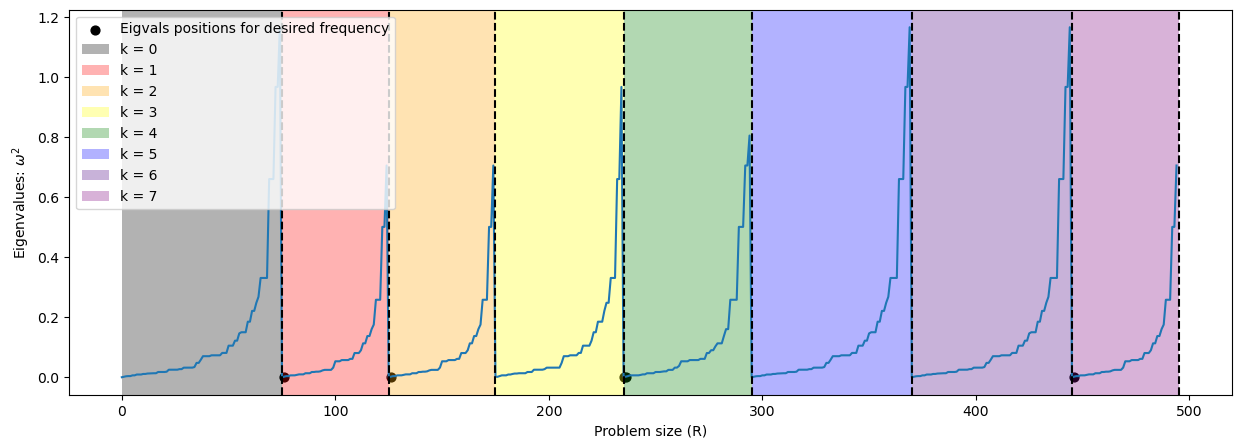

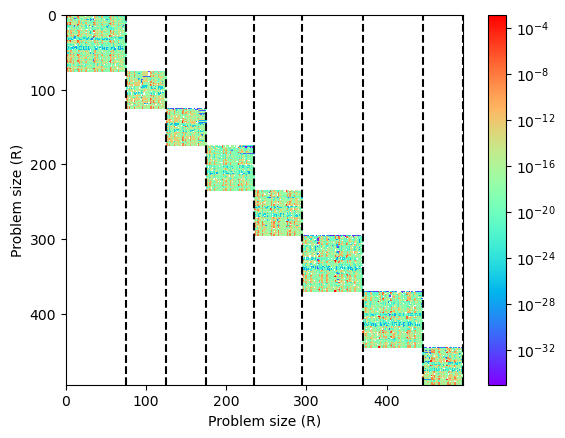

In [7]:
# EIGENVALUES
# Plot the eigenvalues per block
plt.figure('Sum of Exponents l, m , n', figsize = (15,5))
plt.plot(EIGVALS)
plt.scatter(pos, EIGVALS[pos], s = 40, c='k', label = 'Eigvals positions for desired frequency')
irkcp = 0
irkc = 0
irk_lims = [] 
for k in range(0,len(irk)):
    irkcp = irkc
    irkc = irkc + irk[k]
    irk_lims.append(irkc)
    plt.axvline(irkc, c = 'k', linestyle ='--')
    plt.axvspan(irkcp ,irkc, facecolor = block_colors[k], alpha = 0.3, label = 'k = '+str(k)+'') 
plt.ylabel('Eigenvalues: $\omega^2$')
plt.xlabel('Problem size (R)')
plt.legend()

# EIGENVECTORS
# Each of the 8 blocks contains irk[k] eigenvectors 
plt.figure('Eigenvectors')
plt.pcolor(z, cmap = 'rainbow', norm = 'log')
for val in irk_lims:
    plt.axvline(val, c = 'k', linestyle ='--')#, label = 'Block limits')    
plt.xlabel('Problem size (R)')
plt.ylabel('Problem size (R)')
plt.gca().invert_yaxis()
plt.colorbar()
#plt.legend()

In [8]:
def u_i(z, location, pos):
    '''
    Calculates the displacement components for a location on or within the sample material
    z = matrix of eigenvectors.
    pos = index vector of positions where a desired eigenvalue (frequency) is stored
    Attention: if pos is a single value, put it in brackets within the function [pos]
    that way it makes it iterable in python.
    location = [X, Y, Z] position 
    '''    
    dx = 0
    dy = 0
    dz = 0
    for p in pos:
        j = 0
        for tab in tabs:
            i, l, m, n = tab        
            if i == 0:
                dx = dx + z[p,j]*Phi(location, tab) 
            elif i == 1:
                dy = dy + z[p,j]*Phi(location, tab)
            elif i == 2:
                dz = dz + z[p,j]*Phi(location, tab)
            # print(j, i, l, m, n)
            j+=1
    return numpy.array([dx, dy, dz])

# location = [dimension1*numpy.cos(numpy.pi/4), dimension2*numpy.cos(numpy.pi/4) , 0] # -dimension1*numpy.cos(numpy.pi/4),-dimension2*numpy.cos(numpy.pi/4)
# dx, dy, dz = u_i(z, location, [pos[1]]) # pos[2] is in k = 5 (Volume oscillates)

# du=numpy.array([dx,dy,dz])
# du_n = du/numpy.linalg.norm(du)
# print('Norm vector: ',du_n)

# Plot the outline of the equator

(np.float64(-164.92070542535166),
 np.float64(164.9962240678739),
 np.float64(-164.97923106618939),
 np.float64(164.97923106618939))

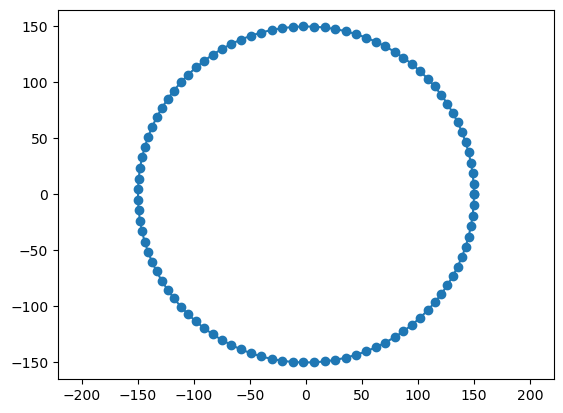

In [9]:
Radius = dimension1
theta = numpy.linspace(0, 2*numpy.pi, 100)
locations = numpy.c_[Radius*numpy.cos(theta), Radius*numpy.sin(theta), numpy.zeros(len(theta)) ]

plt.figure()
plt.plot(locations[:,0], locations[:,1])
plt.scatter(locations[:,0], locations[:,1])
plt.axis('equal')

# Plot the vectors for a particular frequency on the equator

The code in the next cell performs three steps:

1) Find where a particular frequency occurs in our sorted eigenvalues vector (`wsort`).
```python
pos = numpy.where(EIGVALS == wsort[11])[0] # Choose a frequency to plot and find its indices!!!
print('Indices where wsort equals the frequency: ', pos)
print('Frequencies: ', 1e5*numpy.sqrt(EIGVALS[pos])/(2*numpy.pi))
```

2) Calculate the displacements for one of those particular frequencies around the equator locations defined before
```python
DU = numpy.zeros((len(locations),2))
i = 0
for loc in locations:
    dx, dy, dz = u_i(z, [loc[0], loc[1], 0], [pos[4]]) # pos: use all positions, otherwise choose a particular one (e.g. [pos[3]])
    du=numpy.array([dx,dy,dz])
    du_n = du/numpy.linalg.norm(du)
    DU[i,0] = du_n[0]
    DU[i,1] = du_n[1]
    i+=1
```

3) Plot the displacement vectors
```python
plt.figure('Displacements')
plt.plot(locations[:,0], locations[:,1])
plt.scatter(locations[:,0], locations[:,1])
for i in range(0,len(locations)):
    plt.quiver(locations[i,0], locations[i,1], DU[i,0], DU[i,1])
plt.grid(True)
plt.axis('equal')
```

Indices where wsort equals the frequency:  [ 76 126 235 236 446]
Frequencies:  [654.08495431 654.08495431 654.08495431 654.08495431 654.08495431]


(np.float64(-164.92070542535166),
 np.float64(164.9962240678739),
 np.float64(-164.97923106618939),
 np.float64(164.97923106618939))

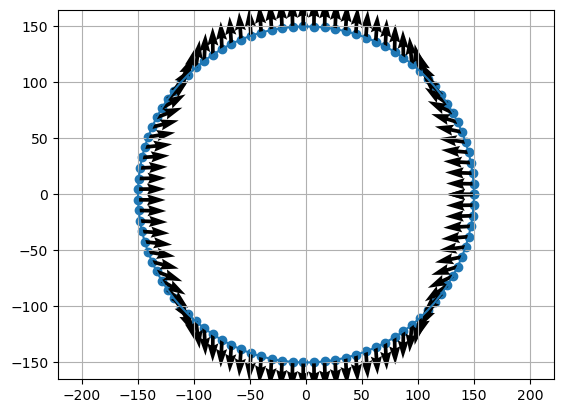

In [10]:
pos = numpy.where(EIGVALS == wsort[12])[0] # Choose a frequency to plot and find its indices!!!
print('Indices where wsort equals the frequency: ', pos)
print('Frequencies: ', 1e5*numpy.sqrt(EIGVALS[pos])/(2*numpy.pi))

DU = numpy.zeros((len(locations),2))
i = 0
for loc in locations:
    dx, dy, dz = u_i(z, [loc[0], loc[1], 0], [pos[3]]) # pos: use all positions, otherwise choose a particular one (e.g. [pos[3]])
    du=numpy.array([dx,dy,dz])
    du_n = du/numpy.linalg.norm(du)
    DU[i,0] = du_n[0]
    DU[i,1] = du_n[1]
    i+=1

plt.figure('Displacements')
plt.plot(locations[:,0], locations[:,1])
plt.scatter(locations[:,0], locations[:,1])
for i in range(0,len(locations)):
    plt.quiver(locations[i,0], locations[i,1], DU[i,0], DU[i,1])
plt.grid(True)
plt.axis('equal')

# References

- Visscher, W. M., Migliori, A., Bell, T. M., & Reinert, R. A. (1991). On the normal modes of free vibration of inhomogeneous and anisotropic elastic objects. The Journal of the Acoustical Society of America, 90(4), 2154-2162.
- Migliori, A., Sarrao, J. L., Visscher, W. M., Bell, T. M., Lei, M., Fisk, Z., & Leisure, R. G. (1993). Resonant ultrasound spectroscopic techniques for measurement of the elastic moduli of solids. Physica B: Condensed Matter, 183(1-2), 1-24.
- de Rue, J. (1996). On the normal modes of freely vibrating elastic objects of various shapes (MSc thesis, University of Amsterdam).
- Zadler, B. J., Le Rousseau, J. H., Scales, J. A., & Smith, M. L. (2004). Resonant ultrasound spectroscopy: theory and application. Geophysical Journal International, 156(1), 154-169.